# PROJECT 1: EXPLORATORY DATA ANALYSIS


## Project Name:


SOUNDCLOUD ANALYSIS


## Assignment Table


|    ID    | Fullname           | Contribution rate |
| :------: | :----------------- | :---------------: |
| 20127323 | Võ Nhật Tân        |        25%        |
| 20127447 | Ngô Đức Bảo        |        25%        |
| 20127275 | Lê Nguyễn Nhật Phú |        25%        |
| 20127681 | Nguyễn Thiên Phúc  |        25%        |


## Import Libraries


In [162]:
import numpy as np
import time
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import requests_cache
import warnings
from bs4 import BeautifulSoup
import os.path
from concurrent.futures import ThreadPoolExecutor, process, wait

In [163]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [164]:
requests_cache.install_cache('cache', expire_after=None)
np.set_printoptions(precision= 3, suppress=True)
pd.set_option('display.max_colwidth', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [165]:
SLEEP_TIME = 2
SCROLL_PAUSE_TIME = 0.5

## Data Collection

In [ ]:
def asynchronousGetWebData(listData, getDataFunc, *argv, max_screens = 6,):
    '''
    Input:
        - listData: list of urls which need to parse the content to the useful information 
        - getDataFunc - func: Fucntion supports parse each item in listData to get information
            * First parameter must be the item in list data
            * The next parameter is saved in *argv
        - max_screens - int: Maximum screens that open at the same time
        
    Output:
        - Returns list of result data
    '''
    result_value = []
    
    for item_index in range(0, len(listData), max_screens):
        start = item_index
        end = item_index + max_screens
        if end > len(listData):
            end = len(listData)
            
        tmpData = listData[start:end]
        threadList = []
        with ThreadPoolExecutor() as executor:
            for url in tmpData:
                threadList.append(executor.submit(getDataFunc, url, *argv))
                
        wait(threadList)
        
        for thread in threadList:
            if thread.done() and not thread.cancelled():
                result_value.append(thread.result())
    return result_value
    

### Collect Users

In [ ]:
# List of playlist that have many songs
urlList = [ 'https://soundcloud.com/user-593335594/sets/is-500-songs-the-playlist', \
            'https://soundcloud.com/user-593335594/sets/amazing-artistry-2',\
            'https://soundcloud.com/user-593335594/sets/playlist-that-wont-crash-my',\
            'https://soundcloud.com/user-593335594/sets/my-personal-favorites',\
            'https://soundcloud.com/user-593335594/sets/amazing',\
            'https://soundcloud.com/user-593335594/sets/i-found-more-music',\
            'https://soundcloud.com/user-593335594/sets/chivalry-is-dead',\
            'https://soundcloud.com/idla/sets/old-songs',\
            'https://soundcloud.com/idla/sets/pop-playlist-2020',\
            'https://soundcloud.com/idla/sets/lost-in-the-blues',\
            'https://soundcloud.com/user987150052/sets/hot-playlist',\
            'https://soundcloud.com/user61185041/sets/hot-playlist',\
            'https://soundcloud.com/discover/sets/charts-top:all-music:vn',\
            'https://soundcloud.com/discover/sets/charts-trending:danceedm:vn',\
            'https://soundcloud.com/bytufekci/sets/top-100-songs-of-2020']

In [ ]:
# Function to get all URL of the user in playlists array
def getAllUserURL(url):
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(url)
    userProfileUrl = set()
    try:
        WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'onetrust-accept-btn-handler'))).click()
    except:
        pass

    #Scroll to the bottom
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'trackItem__username')))
    newUserUrl = driver.find_elements(By.CLASS_NAME, 'trackItem__username')
    for user in newUserUrl:
        userProfileUrl.add(user.get_attribute('href'))
    driver.close()
    return userProfileUrl

In [ ]:
# if link user urls have already existed, reading from file, otherwise run all through URL lists
userUrlList = []
if os.path.isfile('linkusercaches.txt'):
    with open('linkusercaches.txt', 'r') as f:
        userUrlList = f.read().splitlines()

else:
    data = asynchronousGetWebData(urlList, getAllUserURL)
    userUrlList = []
    for item in data:
        userUrlList = userUrlList + list(item)
    userUrlList = list(set(userUrlList))
    with open(r'linkusercaches.txt', 'w') as fp:
        for item in userUrlList:
            # write each item on a new line
            fp.write("%s\n" % item)
            
print(f'The number of profile link: {len(userUrlList)}')

In [ ]:
#Get each user's profile
def get_user_info(url):    
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(url)
    #try:
    #WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'onetrust-accept-btn-handler'))).click()
    #except:
        #pass
    username = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'h2.profileHeaderInfo__userName'))).text

    isVertified = driver.find_element(By.CSS_SELECTOR, 'h2.profileHeaderInfo__userName>div').text
    if len(isVertified) > 0: username = username.strip()[:-len(isVertified.strip())].strip()
    userID = url.split('/')[-1]
    userurl = url
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'infoStats__value.sc-font-light')))
    info = driver.find_elements(By.CLASS_NAME, 'infoStats__value.sc-font-light')
    followers = info[0].text
    following = info[1].text
    tracks = info[2].text
    #go to user's sets which have the url https://soundcloud.com/{userID}/sets
    driver.get(f'https://soundcloud.com/{userID}/sets')
    playlistIDs = []
    time.sleep(1)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, ".emptyNetworkPage__headline, .sc-link-primary.soundTitle__title.sc-link-dark.sc-text-h4")))

    if not driver.find_elements(By.CLASS_NAME, 'emptyNetworkPage__headline'):
        playlist = driver.find_elements(By.CLASS_NAME, 'sc-link-primary.soundTitle__title.sc-link-dark.sc-text-h4')
        if len(playlist) != 0:
            for p in playlist:
                playlistIDs.append(p.get_attribute('href').split('/')[-1])

        
    driver.close()
    return [userID, username, len(isVertified.strip()) > 0, userurl, followers, following, tracks, ";".join(playlistIDs)]

In [ ]:
#this cell takes a long time to run (more than 114 minutes to go through 1278 users)
#data = asynchronousGetWebData(userUrlList, get_user_info)
index_range_list = np.linspace(0, len(userUrlList), 6).astype(np.int64)
users = pd.DataFrame(columns=['UserID', 'Username', 'Verified', 'UserURL', 'Followers', 'Following', 'NumOfTracks', 'PlaylistIDs'])
for i in range(5):
    start_index = index_range_list[i]
    end_index = index_range_list[i + 1]
    data = asynchronousGetWebData(userUrlList[start_index:end_index], get_user_info)

    mini_user = pd.DataFrame(data, columns=['UserID', 'Username', 'Verified', 'UserURL', 'Followers', 'Following', 'NumOfTracks', 'PlaylistIDs'])
    users = pd.concat([users, mini_user])
    
users.to_csv('users.csv', index=False)

### Collect Playlists

In [ ]:
#Read users from csv to get playlist ID
users = pd.read_csv('users.csv', index_col="UserID")
print(users.shape)
users.head()

In [ ]:
users["PlaylistIDs"] = users["PlaylistIDs"].str.split(';')
userPlaylist = users.explode("PlaylistIDs").dropna(subset=["PlaylistIDs"])
userPlaylist

In [ ]:
# Combine to get playlist's url
listPlaylistURL = userPlaylist[['PlaylistIDs', 'UserURL']]
listPlaylistURL['PlaylistUrl'] = listPlaylistURL['UserURL'] + '/sets/' + listPlaylistURL['PlaylistIDs']
listPlaylistURL.reset_index(inplace=True)

In [ ]:
# Function to get playlist profile
def getPlayListInfo(urlPlaylistInfo):
    userID ,urlPlaylist = urlPlaylistInfo[0], urlPlaylistInfo[1]
    
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(urlPlaylist)
    
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    time.sleep(SLEEP_TIME)
    
    try:
        PlaylistName = driver.find_element(By.CSS_SELECTOR, 'h1.soundTitle__title').text
    except:
        PlaylistName = None
    #check Likes 

    try:
        Likes = driver.find_element(By.CLASS_NAME, 'sc-ministats-likes').find_elements(By.TAG_NAME, 'span')[1].text
    except:
        Likes = None
    #check Reposts
    try:
        Reposts = driver.find_element(By.CLASS_NAME, 'sc-ministats-reposts').find_elements(By.TAG_NAME, 'span')[1].text
    except:
        Reposts = None
    #check Datetime
    try:
        Datetime = driver.find_element(By.CLASS_NAME, 'relativeTime').get_attribute('datetime')
    except:
        Datetime = None
    #check TagContent
    try:
        TagContent = driver.find_element(By.CLASS_NAME, 'sc-tagContent').text.split(',')
    except:
        TagContent = None
    
    

    driver.close()
    return [userID, PlaylistName, urlPlaylist, Likes, Reposts, TagContent, Datetime]

In [ ]:
# Run through playlist's url to get playlists' profiles
index_range_list = np.linspace(0, len(listPlaylistURL), 10).astype(np.int64)
playlists = pd.DataFrame(columns=['UserIDPlaylist' , 'PlaylistName', 'PlaylistURL', 'Likes', 'Reposts', 'TagContent' , 'Uploadtime'])

for i in range(len(index_range_list) - 1):
    start_index = index_range_list[i]
    end_index = index_range_list[i + 1]
    data = asynchronousGetWebData(listPlaylistURL[["UserID", "PlaylistUrl"]][start_index:end_index].values, getPlayListInfo)

    mini_playlists = pd.DataFrame(data, columns=['UserIDPlaylist' , 'PlaylistName', 'PlaylistURL', 'Likes', 'Reposts', 'TagContent' , 'Uploadtime'])
    playlists = pd.concat([playlists, mini_playlists])

In [ ]:
playlists = playlists.reset_index(drop=True)
playlists_copy = playlists.copy()

In [ ]:
#Get ID song in each playlist
driver = webdriver.Chrome()
driver.maximize_window()
url_col = list()
for i in range(len(playlists)):
    row = list()
    driver.get(playlists['PlaylistURL'][i])

    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    try:
        WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'trackItem__trackTitle')))
        list_of_url = driver.find_elements(By.CLASS_NAME, 'trackItem__trackTitle')
        for element in driver.find_elements(By.CLASS_NAME, 'trackItem__trackTitle'):
            row.append(element.get_attribute('href').split('?')[0])
    except:
        pass

    url_col.append(row)
driver.quit()

In [ ]:
#Normalize the tag content
playlists = playlists_copy.copy()
def fill_correct_form(row):
    data = row.copy()
    if row['TagContent'] != None and len(row['TagContent']) > 0 and row['TagContent'][0] != '':
        data['TagContent'] = row['TagContent'][0]
    else: data['TagContent'] = None
    return data


playlists = playlists.apply(fill_correct_form, axis = 1)
playlists

In [ ]:
#Normalize the track Url
url_col_new = list()
for row in url_col:
    url_col_new.append(';'.join(row))
playlists.insert(len(playlists.columns), 'trackUrl', url_col_new)

def empty_to_none(row):
    data = row.copy()
    if row['trackUrl'] == '':
        data['trackUrl'] = None
    else:
        data['trackUrl'] = row['trackUrl']
    return data

playlists = playlists.apply(empty_to_none, axis=1)
playlists.to_csv('playlists.csv', index=False)

### Collect Tracks


In [ ]:
playlists = pd.read_csv('playlists.csv')
playlists

In [ ]:
list_track_url = playlists['trackUrl']
list_track_url = list_track_url.str.split(';')
list_track_url = list_track_url.explode().dropna()
type(list_track_url)

In [ ]:
def asynchronousGetWebData_2(listData, getDataFunc, *argv, max_screens = 3,):
    '''
    Input:
        - listData: list of urls which need to parse the content to the useful information 
        - getDataFunc - func: Fucntion supports parse each item in listData to get information
            * Parameter base on function's parameter(s)
            * Parameters must be ordered
        - max_screens - int: Maximum screens that open at the same time
        
    Output:
        - Returns list of result data
    '''
    result_value = []

    i_range_list = np.linspace(0, len(listData), max_screens + 1).astype(np.int64)

    thread_list = []
    with ThreadPoolExecutor() as executor:
        for i in range(len(i_range_list) - 1):
            start = i_range_list[i]
            end = i_range_list[i + 1]
            thread_list.append(executor.submit(getDataFunc, listData[start:end], *argv))

    wait(thread_list)

    # thread.result() gonna be a 2D list
    for thread in thread_list:
        if thread.done() and not thread.cancelled():
            result_value.extend(thread.result())

    return result_value
    

In [ ]:
# Function to get tracks' profiles
def getTrackInfo(url_list):
    driver = webdriver.Chrome()
    driver.maximize_window()

    track_info_list = list()

    for url in url_list: 
        driver.get(url)
        
        # get user that upload the track
        user_id = url.split('/')[3]

        # get url track (for clearer variable)
        url_track = url
        
        time.sleep(5)
        #get name
        try:
            name = driver.find_element(By.CLASS_NAME, 'soundTitle__title').text
        except:
            name = None

        #get plays, likes, reposts container
        try:
            container = driver.find_element(By.CLASS_NAME, 'listenEngagement__stats')
        except:
            container = driver.find_element(By.CLASS_NAME, 'sound__soundStats')
        
        #check plays
        try:
            plays = container.find_element(By.CLASS_NAME, 'sc-ministats-plays').find_elements(By.TAG_NAME, 'span')[1].text
        except:
            plays = None

        #check likes
        try:
            likes = container.find_element(By.CLASS_NAME, 'sc-ministats-likes').find_elements(By.TAG_NAME, 'span')[1].text
        except:
            likes = None

        #check reposts
        try:
            reposts = container.find_element(By.CLASS_NAME, 'sc-ministats-reposts').find_elements(By.TAG_NAME, 'span')[1].text
        except:
            reposts = None

         #check comments
        try:
            comments = driver.find_element(By.CLASS_NAME, 'commentsList__actualTitle').text.split(' ')[0]
        except:
            comments = None

        #check date time
        try:
            date_time = driver.find_element(By.CLASS_NAME, 'relativeTime').get_attribute('datetime')
        except:
            date_time = None

        #check tag content
        try:
            tag_content = driver.find_element(By.CLASS_NAME, 'sc-tagContent').text
        except:
            tag_content = None
        
        track_info_list.append([user_id, name, url_track, plays, likes, reposts, comments, tag_content, date_time])
    
    driver.quit()

    return track_info_list

In [ ]:
# Run through track url to get tracks' profiles
index_range_list = np.linspace(0, len(list_track_url), 6).astype(np.int64)
tracks = pd.DataFrame(columns=['UserIDTrack','TrackName','TrackURL','Plays', 'Likes', 'Reposts', 'Comments', 'TagContent' , 'Uploadtime'])

for i in range(len(index_range_list) - 1):
    start_index = index_range_list[i]
    end_index = index_range_list[i + 1]
    data = asynchronousGetWebData_2(list_track_url[start_index:end_index].values, getTrackInfo)

    mini_tracks = pd.DataFrame(data, columns=['UserIDTrack','TrackName','TrackURL','Plays', 'Likes', 'Reposts', 'Comments', 'TagContent' , 'Uploadtime'])
    tracks = pd.concat([tracks, mini_tracks])

In [ ]:
tracks.to_csv('tracks.csv', index=False)

### Make three file relate to each other


In [ ]:
tracks = pd.read_csv('tracks.csv')
playlists = pd.read_csv('playlists.csv')
users = pd.read_csv('users.csv')

In [ ]:
tracks = tracks.drop_duplicates(subset=['TrackURL']).reset_index(drop=True)
playlists = playlists.drop_duplicates(subset=['PlaylistURL']).reset_index(drop=True)

In [ ]:
# refill column 'playlistIDs' in dataframe playlists with list index in dataframe users
def get_right_playlist_id(row):
    if pd.isnull(row['playlistIDs']):
        return None
    list_playlist_id = row['playlistIDs'].split(';')
    playlist_ids = list()
    for playlist in list_playlist_id:
        playlist_url = row['userUrl'] + '/sets/' + playlist
        playlist_id = playlists[playlists['PlaylistURL'] == playlist_url]
        if playlist_id.empty:
            continue
        playlist_ids.append(str(playlist_id.index[0]))
    # No playlist_id matched
    if len(playlist_ids) == 0:
        return None
    return ';'.join(playlist_ids)
users['playlistIDs'] = users.apply(get_right_playlist_id, axis=1)

In [ ]:
# refill column 'UserIDTrack' in dataframe tracks with index in dataframe users
def get_right_user_id(row):
    user_id = users[users['userID'] == row['UserIDTrack']]
    if user_id.empty:
        return np.nan
    else:
        return user_id.index[0]
tracks['UserIDTrack'] = tracks.apply(get_right_user_id, axis=1)

In [ ]:
# refill column 'UserIDPlaylist' in dataframe playlists with index in dataframe users
def get_right_user_id_playlist(row):
    user_id = users[users['userID'] == row['UserIDPlaylist']]
    if user_id.empty:
        return np.nan
    else:
        return user_id.index[0]
playlists['UserIDPlaylist'] = playlists.apply(get_right_user_id_playlist, axis=1)

# refill column 'trackUrl' in dataframe playlists with list index in dataframe tracks
def get_right_track_id(row):
    if pd.isnull(row['trackUrl']):
        return None
    list_track_url = row['trackUrl'].split(';')
    track_ids = list()
    for track in list_track_url:
        track_id = tracks[tracks['TrackURL'] == track]
        if track_id.empty:
            continue
        track_ids.append(str(track_id.index[0]))
    if track_ids[0] == '':
        return None
    return ';'.join(track_ids)
playlists['trackUrl'] = playlists.apply(get_right_track_id, axis=1)

In [ ]:
users['UserID'] = users.index
playlists['PlaylistID'] = playlists.index
tracks['TrackID'] = tracks.index

In [ ]:
users = users.drop(columns=['userID'])
temp_cols=users.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
users=users[new_cols]

In [ ]:
temp_cols=playlists.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
playlists=playlists[new_cols]

In [ ]:
temp_cols=tracks.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
tracks=tracks[new_cols]

In [ ]:
users = users.rename(columns={"username": "Username", "userUrl": "UserURL", "followers": "Followers", 
                            "following": "Following", "tracks": "NumOfTracks", "playlistIDs": "PlaylistIDs"})
playlists = playlists.rename(columns={"UserIDPlaylist": "UserID", "trackUrl": "TrackID"})
tracks = tracks.rename(columns={"UserIDTrack": "UserID"})

In [ ]:
users.to_csv('users.csv', index=False)
playlists.to_csv('playlists.csv', index=False)
tracks.to_csv('tracks.csv', index=False)

## Exploratory Data Analysis


* Load Datasets
* Get size of each dataset
* Check the duplicate data in each dataset
* Meaning of each column
* Process the name and datatype of the columns that isn't suitable for further processing
* Check the correction of relationship between dataset
* The distribution of data in numeric columns in each datasets
* The distribution of data in non-numeric columns in each datasets

### Load Datasets


In [166]:
#Load datasets
tracks_df = pd.read_csv('tracks.csv', index_col = ['TrackID'])
playlists_df = pd.read_csv('playlists.csv', index_col = ['PlaylistID'])
users_df = pd.read_csv('users.csv', index_col = ['UserID'])

In [167]:
tracks_df.head()

,TrackName,UserID,TrackURL,Plays,Likes,Reposts,Comments,TagContent,Uploadtime
TrackID,,,,,,,,,
0,ARCANE (Transcend Into The New Paradigm),1207.000,https://soundcloud.com/lala-land-361191160/arcane-transcend-into-the-new-paradigm,10.1K,179,88,76,Experimental Trap,2021-11-04T20:55:56.000Z
1,LOCKDOWN,1207.000,https://soundcloud.com/lala-land-361191160/lockdown,10.1K,150,77,55,Drill,2021-12-03T18:29:10.000Z
2,MESIAH,1207.000,https://soundcloud.com/lala-land-361191160/mesiah,11.2K,191,111,61,Hip-hop & Rap,2021-12-20T19:35:51.000Z
3,E.P. Speaks (Intro) (Prod. By E.P. Beats),NaN,https://soundcloud.com/dj_david254/e-p-speaks-intro,272,17,2,NaN,Hip-hop & Rap,2019-07-27T03:15:46.000Z
4,MR. VICK (Prod. By E.P. Beats),NaN,https://soundcloud.com/dj_david254/mr-vick-prod-by-e-p-beats,246,17,2,NaN,Hip-hop & Rap,2019-07-27T03:15:44.000Z


In [168]:
playlists_df.head()

,UserID,PlaylistName,PlaylistURL,Likes,Reposts,TagContent,Uploadtime,TrackID
PlaylistID,,,,,,,,
0,0,The Arcane Trilogy,https://soundcloud.com/e-p-beats/sets/the-arcane-trilogy,3,3,NaN,2022-01-14T22:11:32.000Z,0;1;2
1,0,(Prod/Feat) E.P. Beats,https://soundcloud.com/e-p-beats/sets/prod-by-e-p-beats,44,18,Hip-hop & Rap,2019-07-30T21:23:37.000Z,3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;3...
2,1,MahnoraBotdf,https://soundcloud.com/mahnorabotdf/sets/mahnorabotdf,1,NaN,blue,2015-07-22T07:02:08.000Z,213;214;215
3,2,These Two Windows,https://soundcloud.com/alecbenjamin/sets/these-two-windows,4441,348,NaN,2020-05-29T04:01:28.000Z,216;217;218;219;220;221;222;223;224;225
4,6,SGV - Snow In April (OUT NOW),https://soundcloud.com/etherealmedia/sets/sgv-snow-in-april-out-now,8,2,NaN,2020-04-22T03:13:36.000Z,226


In [169]:
users_df.head()

,Username,Verified,UserURL,Followers,Following,NumOfTracks,PlaylistIDs
UserID,,,,,,,
0,P-Town Anthems (E.P. Beats),False,https://soundcloud.com/e-p-beats,510,"1,327",2,0;1
1,Mahnora-Botdf,False,https://soundcloud.com/mahnorabotdf,89,1,14,2
2,Alec Benjamin,True,https://soundcloud.com/alecbenjamin,223K,0,91,3
3,Shaikh & Shaikhi,False,https://soundcloud.com/muhammad-salman-mansoor,"2,043",161,39,NaN
4,Jiala Ji,False,https://soundcloud.com/jialaji,164,204,9,NaN


### Get size of each dataset


In [170]:
#Dataset size
print(f'Tracks size: {tracks_df.shape[0]} rows; {tracks_df.shape[1]} columns')
print(f'Playlists size: {playlists_df.shape[0]} rows; {playlists_df.shape[1]} columns')
print(f'Users size: {users_df.shape[0]} rows; {users_df.shape[1]} columns')

Tracks size: 15457 rows; 9 columns
Playlists size: 2504 rows; 8 columns
Users size: 1354 rows; 7 columns


### Check the duplicate data in each dataset


In [171]:
# Tracks
is_tracks_duplicate = tracks_df.duplicated().sum()
is_playlists_duplicate = playlists_df.duplicated().sum()
is_users_duplicate  = users_df.duplicated().sum()

In [172]:
print(f'Count the duplicate sample of tracks    : {is_tracks_duplicate}')
print(f'Count the duplicate sample of playlists : {is_playlists_duplicate}')
print(f'Count the duplicate sample of users     : {is_users_duplicate}')

Count the duplicate sample of tracks    : 0
Count the duplicate sample of playlists : 0
Count the duplicate sample of users     : 0


### Meaning of each column


**_1. Track's columns information_**

| Column Name | Meaning                                                              |
| :---------- | :------------------------------------------------------------------- |
| TrackID     | The ID of the track                                                  |
| TrackName   | The name of the track                                                |
| UserID      | The ID of the user publishing the track                              |
| TrackURL    | The URL of the track                                                 |
| Plays       | The number of people listened the song                               |
| Likes       | The number of people liked this song                                 |
| Reposts     | The number of people reposted this song                              |
| Comments    | The number of comments in this this song                             |
| TagContent  | Tag is defined by the owner, it is usually the mainly genre of songs |
| Uploadtime  | Time creates the playlist                                            |


**_2. Playlists's columns information_**

| Column Name  | Meaning                                                              |
| :----------  | :------------------------------------------------------------------- |
| PlaylistID   | The ID of the playlist                                               |
| UserID       | The ID of the user owns the playlist                                 |
| PlaylistName | The name of the playlist                                             |
| PlaylistURL  | The URL of the playlist                                              |
| Likes        | The number of people liked the playlist                              |
| Reposts      | The number of people reposted this playlist                          |
| TagContent   | Tag is defined by the owner, it is usually the mainly genre of songs |
| Uploadtime   | Time creates the playlist                                            |
| TrackIDs     | A list contains IDs of tracks which user add to this playlist        |


**_3. Users's columns information_**

| Column Name | Meaning                                      |
| :---------- | :------------------------------------------- |
| UserID      | The ID of the user                           |
| Username    | The name of the user                         |
| Verified    | Is the user verified by Soundcloud?          |
| UserURL     | The URL of the user                          |
| Followers   | The number of people follows the user        |
| Following   | The number of people is followed by the user |
| NumOfTracks | The number of tracks which this user creates |
| PlaylistIDs | A list contains IDs of playlists own by user |


### Process the name and datatype of the columns that isn't suitable for further processing


In [173]:
def convert_numeric(column, isCopy = True):
    if isCopy: column = column.copy()
    column_tmp = column
    
    if column.dtypes != object:
        return column
    
    try:
        column_tmp = column.replace(r'[KM]+$|[,]', '', regex=True).astype(float) * \
                     column.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1) \
                               .replace(['K','M'], [10**3, 10**6]).astype(int)
        return column_tmp
    except Exception as e:
        warnings.warn("Oops!", e.__class__, "occurred.")
        return column_tmp

#### 1. Tracks dataset


In [174]:
tracks_df =  pd.read_csv('tracks.csv', index_col = ['TrackID'])

In [175]:
print('Datatype of each column in Tracks dataset: ')
print(tracks_df.dtypes)

Datatype of each column in Tracks dataset: 
TrackName      object
UserID        float64
TrackURL       object
Plays          object
Likes          object
Reposts        object
Comments       object
TagContent     object
Uploadtime     object
dtype: object


As we can see, Plays, Likes, Repost and Comments columns indicates the number of people so that they are numeric attributes.


In [176]:
#Checking Plays, Likes, Reposts, Comments columns is the instance of numeric datatype

values_not_number_plays_column = tracks_df[~tracks_df["Plays"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Plays"].unique()

values_not_number_likes_column = tracks_df[~tracks_df["Likes"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Likes"].unique()

values_not_number_reposts_column = tracks_df[~tracks_df["Reposts"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Reposts"].unique()

values_not_number_comments_column = tracks_df[~tracks_df["Comments"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                             ["Comments"].unique()


print(f"Values are not an instance of numeric datatype in Play column: {values_not_number_plays_column}")
print(f"Values are not an instance of numeric datatype in Likes column: {values_not_number_likes_column}")
print(f"Values are not an instance of numeric datatype in Reposts column: {values_not_number_reposts_column}")
print(f"Values are not an instance of numeric datatype in Comments column: {values_not_number_comments_column}")

Values are not an instance of numeric datatype in Play column: []
Values are not an instance of numeric datatype in Likes column: []
Values are not an instance of numeric datatype in Reposts column: []
Values are not an instance of numeric datatype in Comments column: ['Comments']


All of values in Likes and Reposts are an instance of numeric datatype except values in Comments column. Therefore, we replace the values which are not the numeric datatype to the nan values.


In [177]:
# Replace the values which are not numbers with nan values
tracks_df["Comments"] = tracks_df["Comments"].replace("|".join(values_not_number_comments_column), np.nan)

In [178]:
#Convert datatype of Likes, Reposts, Comments columns to number datatype
tracks_df["Plays"] = convert_numeric(tracks_df["Plays"])
tracks_df["Likes"] = convert_numeric(tracks_df["Likes"])
tracks_df["Reposts"] = convert_numeric(tracks_df["Reposts"])
tracks_df["Comments"] = convert_numeric(tracks_df["Comments"])

In [179]:
#Convert Uploadtime columns to datetime datatype
tracks_df['Uploadtime'] = pd.to_datetime(tracks_df['Uploadtime'])

In [180]:
#Update the name of columns in Playlists dataset
tracks_df.rename(columns = {'Uploadtime':'UploadTime'}, inplace = True)

In [181]:
tracks_df.dtypes 

TrackName                  object
UserID                    float64
TrackURL                   object
Plays                     float64
Likes                     float64
Reposts                   float64
Comments                  float64
TagContent                 object
UploadTime    datetime64[ns, UTC]
dtype: object

In [182]:
tracks_df.head()

,TrackName,UserID,TrackURL,Plays,Likes,Reposts,Comments,TagContent,UploadTime
TrackID,,,,,,,,,
0,ARCANE (Transcend Into The New Paradigm),1207.000,https://soundcloud.com/lala-land-361191160/arcane-transcend-into-the-new-paradigm,10100.000,179.000,88.000,76.000,Experimental Trap,2021-11-04 20:55:56+00:00
1,LOCKDOWN,1207.000,https://soundcloud.com/lala-land-361191160/lockdown,10100.000,150.000,77.000,55.000,Drill,2021-12-03 18:29:10+00:00
2,MESIAH,1207.000,https://soundcloud.com/lala-land-361191160/mesiah,11200.000,191.000,111.000,61.000,Hip-hop & Rap,2021-12-20 19:35:51+00:00
3,E.P. Speaks (Intro) (Prod. By E.P. Beats),NaN,https://soundcloud.com/dj_david254/e-p-speaks-intro,272.000,17.000,2.000,NaN,Hip-hop & Rap,2019-07-27 03:15:46+00:00
4,MR. VICK (Prod. By E.P. Beats),NaN,https://soundcloud.com/dj_david254/mr-vick-prod-by-e-p-beats,246.000,17.000,2.000,NaN,Hip-hop & Rap,2019-07-27 03:15:44+00:00


#### 2. Playlists Dataset


In [183]:
playlists_df =  pd.read_csv('playlists.csv', index_col = ['PlaylistID'])

In [184]:
#Show the columns' datatype
print('Datatype of each column in Playlists dataset: ')
print(playlists_df.dtypes)

Datatype of each column in Playlists dataset: 
UserID           int64
PlaylistName    object
PlaylistURL     object
Likes           object
Reposts         object
TagContent      object
Uploadtime      object
TrackID         object
dtype: object


In [185]:
#Checking Likes, Reposts columns is the instance of numeric datatype

values_not_number_likes_column = playlists_df[~playlists_df["Likes"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Likes"].unique()

values_not_number_reposts_column = playlists_df[~playlists_df["Reposts"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Reposts"].unique()

print(f"Values are not an instance of numeric datatype in Likes column: {values_not_number_likes_column}")
print(f"Values are not an instance of numeric datatype in Reposts column: {values_not_number_reposts_column}")

Values are not an instance of numeric datatype in Likes column: []
Values are not an instance of numeric datatype in Reposts column: []


In [186]:
#Convert datatype of Likes, Reposts, Comments columns to number datatype
playlists_df["Likes"] = convert_numeric(playlists_df["Likes"])
playlists_df["Reposts"] = convert_numeric(playlists_df["Reposts"])

In [187]:
#Convert Uploadtime columns to datetime datatype
playlists_df['Uploadtime'] = pd.to_datetime(playlists_df['Uploadtime'])

In [188]:
#Update the name of columns in Playlists dataset
playlists_df.rename(columns = {'Uploadtime':'UploadTime', 'TrackID': 'ListTrackIDs'}, inplace = True)

In [189]:
playlists_df.dtypes

UserID                        int64
PlaylistName                 object
PlaylistURL                  object
Likes                       float64
Reposts                     float64
TagContent                   object
UploadTime      datetime64[ns, UTC]
ListTrackIDs                 object
dtype: object

In [190]:
playlists_df.head()

,UserID,PlaylistName,PlaylistURL,Likes,Reposts,TagContent,UploadTime,ListTrackIDs
PlaylistID,,,,,,,,
0,0,The Arcane Trilogy,https://soundcloud.com/e-p-beats/sets/the-arcane-trilogy,3.000,3.000,NaN,2022-01-14 22:11:32+00:00,0;1;2
1,0,(Prod/Feat) E.P. Beats,https://soundcloud.com/e-p-beats/sets/prod-by-e-p-beats,44.000,18.000,Hip-hop & Rap,2019-07-30 21:23:37+00:00,3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;3...
2,1,MahnoraBotdf,https://soundcloud.com/mahnorabotdf/sets/mahnorabotdf,1.000,NaN,blue,2015-07-22 07:02:08+00:00,213;214;215
3,2,These Two Windows,https://soundcloud.com/alecbenjamin/sets/these-two-windows,4441.000,348.000,NaN,2020-05-29 04:01:28+00:00,216;217;218;219;220;221;222;223;224;225
4,6,SGV - Snow In April (OUT NOW),https://soundcloud.com/etherealmedia/sets/sgv-snow-in-april-out-now,8.000,2.000,NaN,2020-04-22 03:13:36+00:00,226


#### 3. Users Dataset


In [191]:
users_df = pd.read_csv('users.csv', index_col = ['UserID'])

In [192]:
print('Datatype of each column in Users dataset: ')
print(users_df.dtypes)

Datatype of each column in Users dataset: 
Username       object
Verified         bool
UserURL        object
Followers      object
Following      object
NumOfTracks    object
PlaylistIDs    object
dtype: object


In [193]:
#Checking Followers, Following, NumOfTracks columns is the instance of numeric datatype

values_not_number_followers_column = users_df[~users_df["Followers"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Followers"].unique()

values_not_number_following_column = users_df[~users_df["Following"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["Following"].unique()

values_not_number_NumOfTracks_column = users_df[~users_df["NumOfTracks"].str.contains("[\d,\\.MK]", regex=True, na=True)]\
                                   ["NumOfTracks"].unique()

print(f"Values are not an instance of numeric datatype in Followers column: {values_not_number_followers_column}")
print(f"Values are not an instance of numeric datatype in Following column: {values_not_number_following_column}")
print(f"Values are not an instance of numeric datatype in NumOfTracks column: {values_not_number_NumOfTracks_column}")

Values are not an instance of numeric datatype in Followers column: []
Values are not an instance of numeric datatype in Following column: []
Values are not an instance of numeric datatype in NumOfTracks column: []


In [194]:
#Convert datatype of Followers, Following, NumOfTracks columns to number datatype
users_df["Followers"] = convert_numeric(users_df["Followers"])
users_df["Following"] = convert_numeric(users_df["Following"])
users_df["NumOfTracks"] = convert_numeric(users_df["NumOfTracks"])

In [195]:
#Update the name of columns in Users dataset
users_df.rename(columns = {'Uploadtime':'UploadTime', 'PlaylistIDs': 'ListPlaylistIDs'}, inplace = True)

In [196]:
users_df.dtypes

Username            object
Verified              bool
UserURL             object
Followers          float64
Following          float64
NumOfTracks        float64
ListPlaylistIDs     object
dtype: object

In [197]:
users_df.head()

,Username,Verified,UserURL,Followers,Following,NumOfTracks,ListPlaylistIDs
UserID,,,,,,,
0,P-Town Anthems (E.P. Beats),False,https://soundcloud.com/e-p-beats,510.000,1327.000,2.000,0;1
1,Mahnora-Botdf,False,https://soundcloud.com/mahnorabotdf,89.000,1.000,14.000,2
2,Alec Benjamin,True,https://soundcloud.com/alecbenjamin,223000.000,0.000,91.000,3
3,Shaikh & Shaikhi,False,https://soundcloud.com/muhammad-salman-mansoor,2043.000,161.000,39.000,NaN
4,Jiala Ji,False,https://soundcloud.com/jialaji,164.000,204.000,9.000,NaN


### Check the correction of relationship between dataset


In [198]:
#Check UserID in Tracks exists in Users dataset
userID_not_in_users_dataset  = (~tracks_df["UserID"].isin(users_df.index.to_list() + [np.nan])).sum()
if userID_not_in_users_dataset > 0:
    print('There is a confict between UserID in Tracks dataset and UserID in Users dataset')
else:
    print('There is no problem about relationship between Tracks dataset and Users dataset')

There is no problem about relationship between Tracks dataset and Users dataset


In [199]:
#Check TrackID in Playlists exists in Tracks dataset

trackIDs_in_playlists = playlists_df["ListTrackIDs"].str.split(';').explode().astype(np.float64)

trackIDs_not_in_tracks_dataset  = (~trackIDs_in_playlists.isin(tracks_df.index.to_list() + [np.nan])).sum()

if trackIDs_not_in_tracks_dataset > 0:
    print('There is a confict between TrackID in Playlists dataset and TrackID in Track dataset')
else:
    print('There is no problem about relationship between Playlists dataset and Tracks dataset')

There is no problem about relationship between Playlists dataset and Tracks dataset


In [200]:
#Check UserID in Playlists exists in Users dataset

userIDs_not_in_users_dataset  = (~playlists_df["UserID"].isin(users_df.index.to_list() + [np.nan])).sum()

if userIDs_not_in_users_dataset > 0:
    print('There is a confict between UserID in Playlists dataset and UserID in Users dataset')
else:
    print('There is no problem about relationship between Playlists dataset and Users dataset')

There is no problem about relationship between Playlists dataset and Users dataset


In [201]:
#Check PlaylistID in Users exists in PlaylistID dataset

users_df
playlistIDs_in_users = users_df["ListPlaylistIDs"].str.split(';').explode().astype(np.float64)

playlistIDs_not_in_playlists_dataset  = (~playlistIDs_in_users.isin(playlists_df.index.to_list() + [np.nan])).sum()
playlistIDs_not_in_playlists_dataset

if playlistIDs_not_in_playlists_dataset > 0:
    print('There is a confict between PlaylistID in Users dataset and PlaylistID in Playlists dataset')
else:
    print('There is no problem about relationship between Users dataset and Playlists dataset')

There is no problem about relationship between Users dataset and Playlists dataset


### The distribution of data in numeric columns in each datasets


In [202]:
#Tracks dataset

tracks_df_describe = tracks_df.loc[:, tracks_df.columns!='UserID'].describe()

numeric_col_info_tracks = pd.DataFrame({
    'missing_percentage': (1 - tracks_df_describe.loc["count"] / tracks_df.shape[0]) * 100, 
}).T

numeric_col_info_tracks = pd.concat([numeric_col_info_tracks, tracks_df_describe])

print('numericdata distribution in Tracks Dataset: ')
numeric_col_info_tracks

numericdata distribution in Tracks Dataset: 


,Plays,Likes,Reposts,Comments
missing_percentage,0.408,0.789,5.784,21.544
count,15394.000,15335.000,14563.000,12127.000
mean,1673760.823,23585.644,1810.549,521.146
std,8838152.501,111305.456,9022.291,5222.977
min,1.000,1.000,1.000,1.000
25%,8670.250,183.000,24.000,9.000
50%,61250.000,1238.000,116.000,33.000
75%,381000.000,6943.500,642.000,139.000
max,326000000.000,3100000.000,328000.000,349439.000


In [203]:
#Playlists dataset

playlists_df_describe = playlists_df.loc[:, playlists_df.columns!='UserID'].describe()

numeric_col_info_playlists = pd.DataFrame({
    'missing_percentage': (1 - playlists_df_describe.loc["count"] / playlists_df.shape[0]) * 100, 
}).T

numeric_col_info_playlists = pd.concat([numeric_col_info_playlists, playlists_df_describe])

print('numerica distribution in Playlists Dataset: ')
numeric_col_info_playlists



numerica distribution in Playlists Dataset: 


,Likes,Reposts
missing_percentage,3.474,13.059
count,2417.000,2177.000
mean,1817.109,251.426
std,12948.624,1547.717
min,1.000,1.000
25%,5.000,2.000
50%,35.000,10.000
75%,301.000,73.000
max,307000.000,36900.000


In [204]:
#Users dataset

users_df_describe = users_df.loc[:, users_df.columns!='UserID'].describe()

users_df_describe
numeric_col_info_users = pd.DataFrame({
    'missing_percentage': (1 - users_df_describe.loc["count"] / users_df.shape[0]) * 100, 
}).T

numeric_col_info_users = pd.concat([numeric_col_info_users, users_df_describe])

print('numeric data distribution in Users Dataset: ')
numeric_col_info_users

numeric data distribution in Users Dataset: 


,Followers,Following,NumOfTracks
missing_percentage,0.000,0.000,0.000
count,1354.000,1354.000,1354.000
mean,182742.253,167.828,197.205
std,773922.471,378.879,1009.154
min,0.000,0.000,1.000
25%,236.500,1.000,11.000
50%,1811.000,13.000,34.000
75%,25950.000,112.000,99.000
max,8490000.000,2003.000,22200.000


### The distribution of data in non-numeric columns in each datasets


In [205]:
tracks_nonnumeric_df = tracks_df.select_dtypes(exclude=[np.number])
tracks_nonnumeric_df = tracks_nonnumeric_df["TagContent"]


non_numeric_col_info_tracks = pd.DataFrame({
    "missing_percentage": ((tracks_nonnumeric_df.isnull().sum() / tracks_df.shape[0])*100),
    "num_values": len(tracks_nonnumeric_df.value_counts().keys()),
    "value_counts": {"TagContent": pd.Series(tracks_nonnumeric_df.value_counts().to_dict())}                        
}, index=["TagContent"]).T

print('Non-numeric data distribution in Tracks Dataset:')
non_numeric_col_info_tracks

Non-numeric data distribution in Tracks Dataset:


,TagContent
missing_percentage,13.347
num_values,2566
value_counts,Dance & EDM 1162 Electronic 1007 Hip-hop & Rap 821 Pop 796 ...


In [206]:
playlists_nonnumeric_df = playlists_df.select_dtypes(exclude=[np.number])
playlists_nonnumeric_df = playlists_df["TagContent"]

non_numeric_col_info_playlists = pd.DataFrame({
    "missing_percentage": ((playlists_nonnumeric_df.isnull().sum() / playlists_df.shape[0])*100),
    "num_values": len(playlists_nonnumeric_df.value_counts().keys()),
    "value_counts": {"TagContent": pd.Series(playlists_nonnumeric_df.value_counts().to_dict())}                        
}, index=["TagContent"]).T

print('Non-numeric data distribution in Playlists Dataset:')
non_numeric_col_info_playlists

Non-numeric data distribution in Playlists Dataset:


,TagContent
missing_percentage,63.658
num_values,308
value_counts,Electronic 179 Dance & EDM 91 Hip-hop & Rap 51 Pop 46 Dubstep ...


In [207]:
users_nonnumeric_df = users_df.select_dtypes(exclude=[np.number])
users_nonnumeric_df

,Username,Verified,UserURL,ListPlaylistIDs
UserID,,,,
0,P-Town Anthems (E.P. Beats),False,https://soundcloud.com/e-p-beats,0;1
1,Mahnora-Botdf,False,https://soundcloud.com/mahnorabotdf,2
2,Alec Benjamin,True,https://soundcloud.com/alecbenjamin,3
3,Shaikh & Shaikhi,False,https://soundcloud.com/muhammad-salman-mansoor,NaN
4,Jiala Ji,False,https://soundcloud.com/jialaji,NaN
...,...,...,...,...
1349,Ava Max,False,https://soundcloud.com/user-478177208,NaN
1350,♦HLTR$KLTR♦,False,https://soundcloud.com/hltrskltr,2492;2493;2494;2495;2496
1351,Tasty,True,https://soundcloud.com/tastynetwork,2497;2498;2499;2500


### Make questions


#### **1.Top 10 the most loved genres in 2020**


The most loved genres in 2020 (respectively): Hip Hop, Rap, Trap, R&B, Pop, Electronic, Rock, Dance, House, Indie


<AxesSubplot:title={'center':'Top 10 genre in 2020'}>

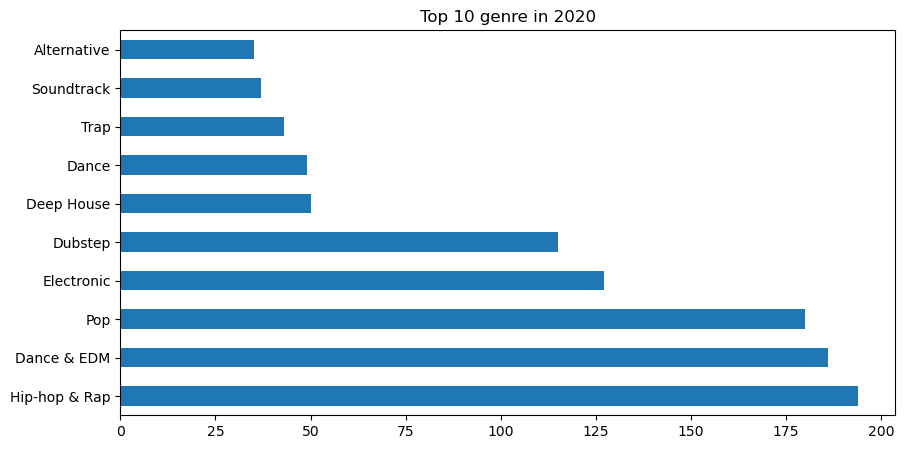

In [208]:
#find the most popular song in 2020
most_popular_song = tracks_df[tracks_df['UploadTime'].dt.year == 2020].sort_values(by='Plays', ascending=False)
most_popular_song.dropna(subset=['TagContent'], inplace=True)
#visualize 10 tag content of the most popular song
most_popular_song['TagContent'].value_counts().head(10).plot(kind='barh', figsize=(10, 5), title='Top 10 genre in 2020')


#### **2. Disco trend from 2016 to 2022**


Disco music was on the top trend in 2019 because of having the most plays

<AxesSubplot:title={'center':'Disco trend from 2016 to 2022'}, xlabel='UploadTime'>

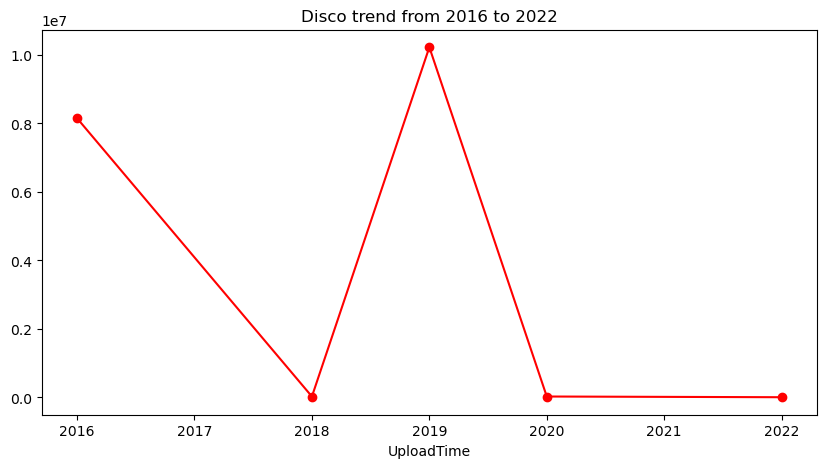

In [209]:
#find the Disco trend from 2016 to 2022
Disco_trend = tracks_df[tracks_df['TagContent'] == 'Disco']
#from 2016 to 2022 based on play rate
Disco_trend = Disco_trend[Disco_trend['UploadTime'].dt.year >= 2016]
Disco_trend = Disco_trend[Disco_trend['UploadTime'].dt.year <= 2022]
Disco_trend = Disco_trend.groupby(Disco_trend['UploadTime'].dt.year).sum()
Disco_trend
#draw line chart with year and number of plays
Disco_trend['Plays'].plot(kind='line', figsize=(10, 5), title='Disco trend from 2016 to 2022', color='red', marker = 'o')



#### 3. The most loved playlist in 2021


In [210]:
Most_popular_playplist = playlists_df.sort_values(by='Likes', ascending=False)
#in 2021
Most_popular_playplist = Most_popular_playplist[Most_popular_playplist['UploadTime'].dt.year == 2021]
Most_popular_playplist

,UserID,PlaylistName,PlaylistURL,Likes,Reposts,TagContent,UploadTime,ListTrackIDs
PlaylistID,,,,,,,,
916,533,"Sincerely, Kentrell",https://soundcloud.com/nba-youngboy/sets/sincerely-kentrell,73100.000,2521.000,YoungBoy Never Broke Again,2021-09-10 04:04:22+00:00,5712;5713;5714;5715;5716
926,536,SoulFly,https://soundcloud.com/rodwave/sets/soulfly,49500.000,1835.000,Hip-hop & Rap,2021-03-25 01:58:00+00:00,5768;5769;5770;5771;5772;5773;5774;5775;5776;5777;5778;5779;5780;5781;5782
1031,609,Lil Peep & Lil Tracy - CASTLES II,https://soundcloud.com/lil_peep/sets/lil-peep-lil-tracy-castles-ii,18700.000,1063.000,Hip-hop & Rap,2021-07-02 04:03:45+00:00,6195;6196;6197;6198;6199
1029,609,Lil Peep & Harry Fraud - HIGH FASHION,https://soundcloud.com/lil_peep/sets/lil-peep-harry-fraud-high,8783.000,599.000,Hip-hop & Rap,2021-12-03 05:03:58+00:00,6189;6190;6191
917,533,YoungBoy Never Broke Again: The Complete Collection,https://soundcloud.com/nba-youngboy/sets/the-complete-collection,7406.000,552.000,Hip-hop & Rap,2021-09-10 01:51:42+00:00,5717;5718;5719;5720
...,...,...,...,...,...,...,...,...
1812,990,+++,https://soundcloud.com/vasily-stroganov/sets/2w6igewpwdo0,NaN,NaN,NaN,2021-10-09 06:58:57+00:00,11891;11892;11893;11894;11895
1813,990,TICNIKRUSRAP,https://soundcloud.com/vasily-stroganov/sets/ticnikrusrap,NaN,NaN,NaN,2021-09-28 08:22:03+00:00,11896;11897;11898;11899
1814,990,GYM,https://soundcloud.com/vasily-stroganov/sets/gym,NaN,NaN,NaN,2021-04-16 18:27:25+00:00,11900;11901;11902;11903;11904;11905;11906;11907;11908;11909;11910;11911;11912;11913;11914;11915;...


#### 4. Which artists have the most plays in the Rock genre? (Top 10)

In [211]:
most_played_rock_artists = tracks_df[tracks_df["TagContent"] == 'Rock'].groupby("UserID")["Plays"].sum().sort_values(ascending=False).head(10)
most_played_rock_artists_id = users_df[users_df.index.isin(most_played_rock_artists.index)].head(10)
most_played_rock_artists_id["Plays"] = pd.Series(most_played_rock_artists.values/1000, index=most_played_rock_artists_id.index)
most_played_rock_artists_id = most_played_rock_artists_id[["Username", "Plays"]]
most_played_rock_artists_id = most_played_rock_artists_id.sort_values(by="Plays", ascending=False)

[Text(0, 0, '28300'),
 Text(0, 0, '14800'),
 Text(0, 0, '2050'),
 Text(0, 0, '235'),
 Text(0, 0, '214'),
 Text(0, 0, '191'),
 Text(0, 0, '171.36'),
 Text(0, 0, '114.845'),
 Text(0, 0, '63.4'),
 Text(0, 0, '26.6')]

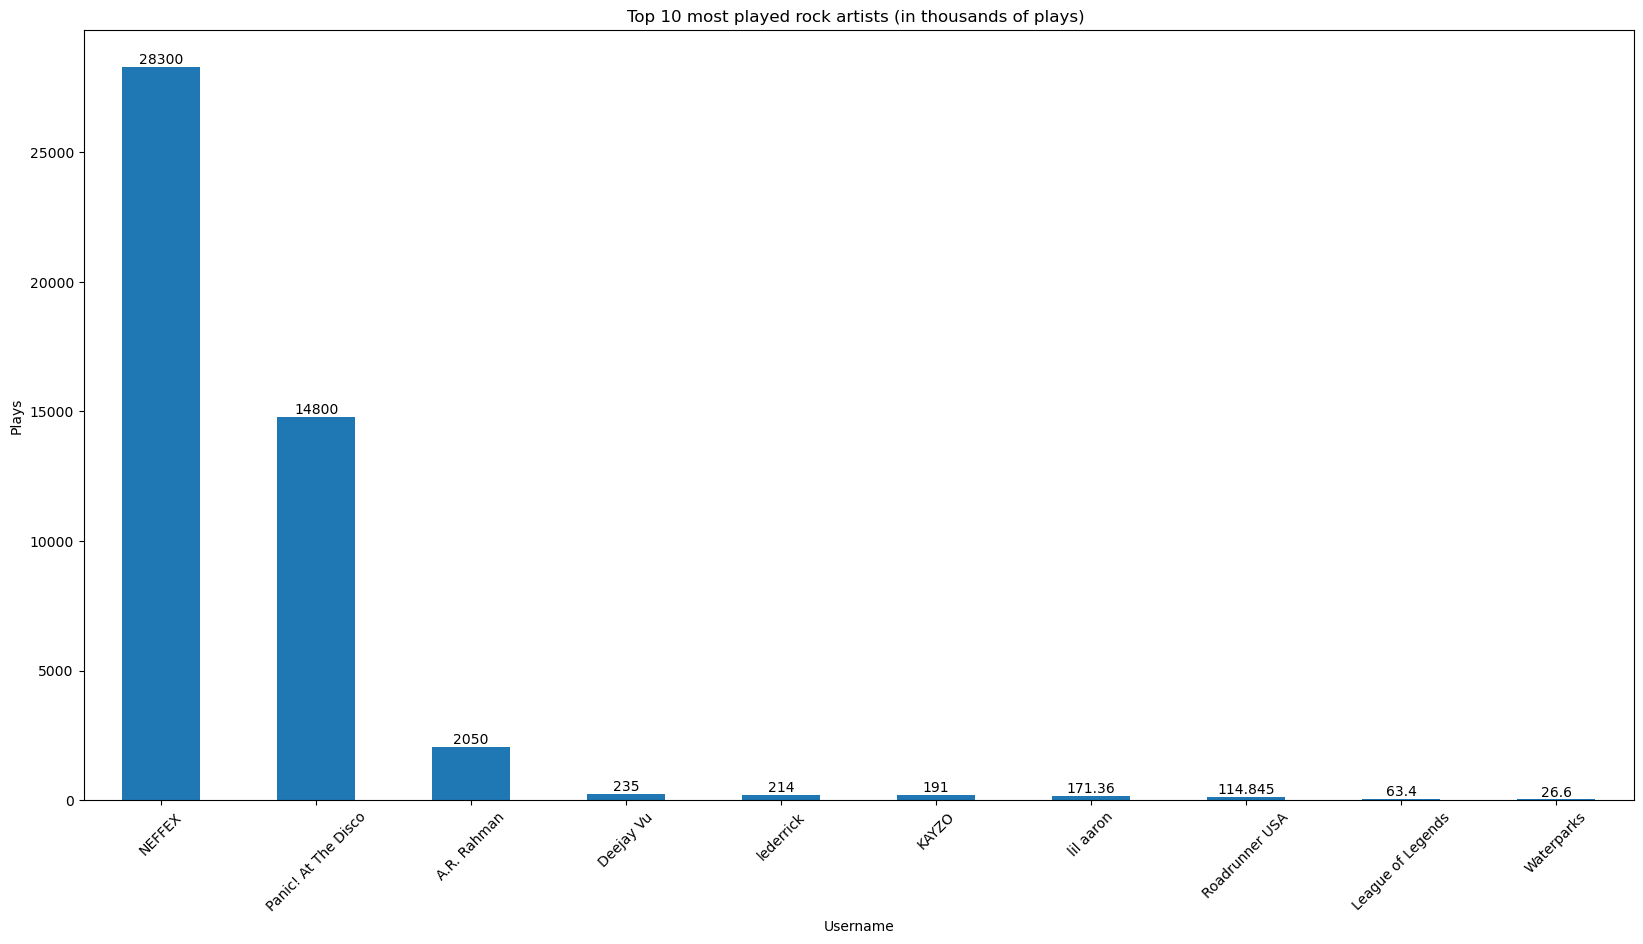

In [212]:
#Visualize the answer
plt.figure(figsize=(20, 10))
fig = most_played_rock_artists_id["Plays"].plot(kind='bar')
fig.set_title("Top 10 most played rock artists (in thousands of plays) ")
fig.set_xticklabels(most_played_rock_artists_id["Username"], rotation=45)
fig.set_xlabel("Username")
fig.set_ylabel("Plays")
fig.bar_label(fig.containers[0], label_type='edge')

#### 5. Which type of artists are the most loved, verified or unverified? 
The artists are loved when they have the most likes, reposts and plays so let's compare the number of likes, reposts and plays of verified and unverified artists.

In [213]:
#Plays of the artists
verified_users = users_df[users_df["Verified"] == 1]
verified_users_plays = tracks_df[tracks_df["UserID"].isin(verified_users.index)]
verified_users_plays = (verified_users_plays.groupby("UserID")["Plays"].sum().mean()/1000).round(2) #in thousands of plays

unverified_users = users_df[users_df["Verified"] == 0]
unverified_users_plays = tracks_df[tracks_df["UserID"].isin(unverified_users.index)]
unverified_users_plays = (unverified_users_plays.groupby("UserID")["Plays"].sum().mean()/1000).round(2)

In [214]:
#Likes of the artists
verified_users = users_df[users_df["Verified"] == 1]
verified_users_likes = tracks_df[tracks_df["UserID"].isin(verified_users.index)]
verified_users_likes = verified_users_likes.groupby("UserID")["Likes"].sum().mean().round(2)
print("Average likes of verified users: ", verified_users_likes)

unverified_users = users_df[users_df["Verified"] == 0]
unverified_users_likes = tracks_df[tracks_df["UserID"].isin(unverified_users.index)]
unverified_users_likes = unverified_users_likes.groupby("UserID")["Likes"].sum().mean().round(2)
print("Average likes of unverified users: ", unverified_users_likes)

Average likes of verified users:  525255.18
Average likes of unverified users:  21093.48


In [215]:
#Reposts of the artists
verified_users = users_df[users_df["Verified"] == 1]
verified_users_reposts = tracks_df[tracks_df["UserID"].isin(verified_users.index)]
verified_users_reposts = verified_users_reposts.groupby("UserID")["Reposts"].sum().mean().round(2)
print("Average reposts of verified users: ", verified_users_reposts)

unverified_users = users_df[users_df["Verified"] == 0]
unverified_users_reposts = tracks_df[tracks_df["UserID"].isin(unverified_users.index)]
unverified_users_reposts = unverified_users_reposts.groupby("UserID")["Reposts"].sum().mean().round(2)
print("Average reposts of unverified users: ", unverified_users_reposts)

Average reposts of verified users:  39751.55
Average reposts of unverified users:  1137.26


[Text(0, 0, '38886'), Text(0, 0, '1357.33')]

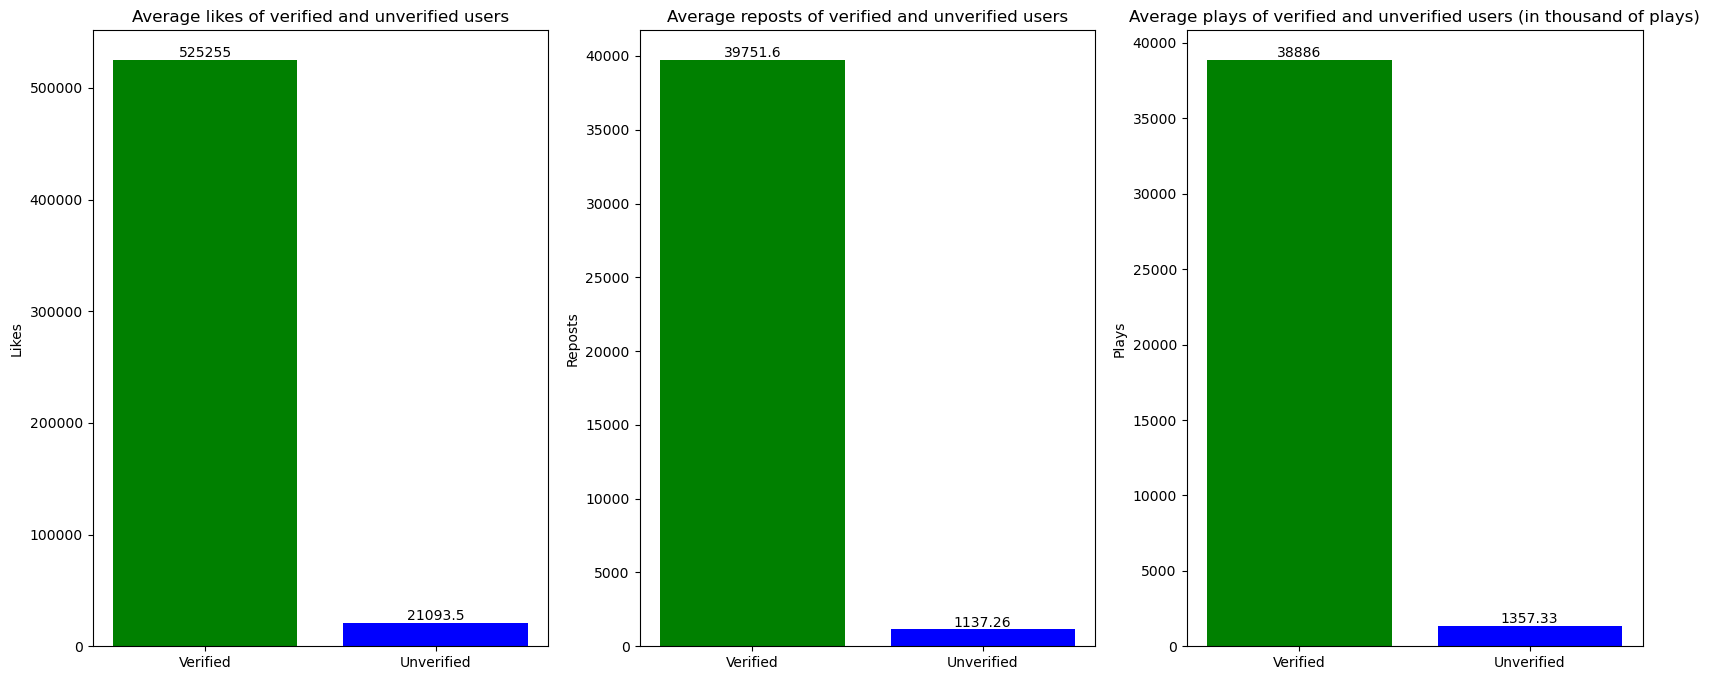

In [216]:
#likes
plt.figure(figsize=(20, 8))
fig = plt.subplot(1, 3, 1)
fig.set_title("Average likes of verified and unverified users")
fig.set_ylabel("Likes")
fig.bar(["Verified", "Unverified"], [verified_users_likes, unverified_users_likes], color=["g", "b"])
fig.bar_label(fig.containers[0], label_type='edge')


#reposts
fig = plt.subplot(1, 3, 2)
fig.set_title("Average reposts of verified and unverified users")
fig.set_ylabel("Reposts")
fig.bar(["Verified", "Unverified"], [verified_users_reposts, unverified_users_reposts], color=["g", "b"])
fig.bar_label(fig.containers[0], label_type='edge')
#plays
fig = plt.subplot(1, 3, 3)
fig.set_title("Average plays of verified and unverified users (in thousand of plays)")
fig.set_ylabel("Plays")
fig.bar(["Verified", "Unverified"], [verified_users_plays, unverified_users_plays], color=["g", "b"])
fig.bar_label(fig.containers[0], label_type='edge')

*** Answer:**
 Based on the plots, verified artists are more loved than unverified artists. The number of likes, reposts and plays of verified artists are higher than unverified artists.

#### 7. With large appearence frequency tag content, which one is the most popular, which one is the second popular,...?

To find the answer, we need to take tracks whose tag content appear at least 70 times then calculate mean of these track group by tag content

In [217]:
tracks_group_tag_content = non_numeric_col_info_tracks["TagContent"]["value_counts"]
tag_content_suitable = tracks_group_tag_content[tracks_group_tag_content > 70].index.tolist()
tracks_suitable = tracks_df[tracks_df['TagContent'].isin(tag_content_suitable)].groupby('TagContent')

In [218]:
tracks_suitable.mean()['Likes'].sort_values(ascending=False).head()

TagContent
Hip Hop            111921.539
Alternative Rock    96202.694
Hip-hop & Rap       56879.732
Alternative         41892.593
Pop                 29962.774
Name: Likes, dtype: float64

<AxesSubplot:ylabel='TagContent'>

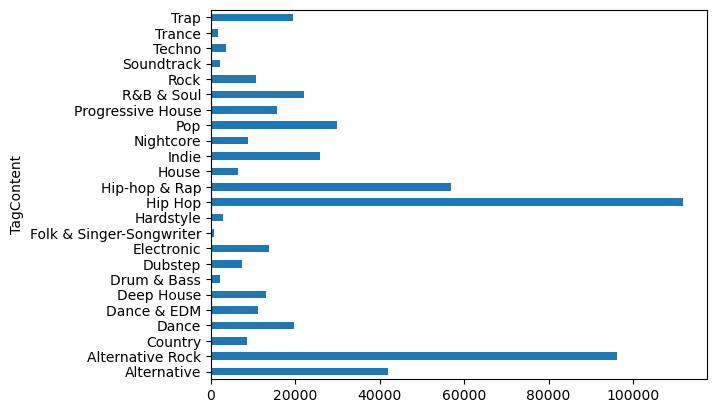

In [219]:
tracks_suitable.mean()['Likes'].plot(kind='barh') 

Looks like Hip Hop is the most popular tag content!

#### 8. What is the correlation:
* among Likes, Plays and Reposts in `tracks.csv`
* between Likes and Reposts in `playlists.csv`

<AxesSubplot:>

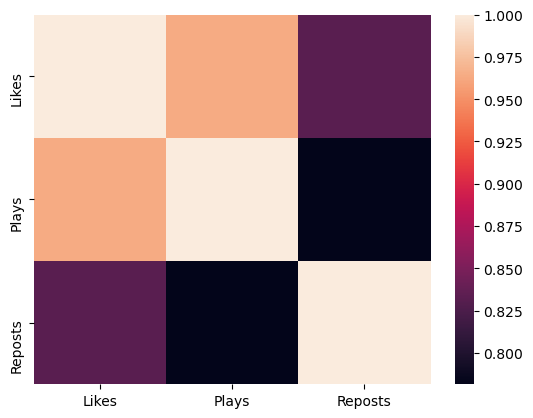

In [220]:
tracks_df_after_fill = tracks_df[['Likes', 'Plays', 'Reposts']].fillna(0)
sns.heatmap(tracks_df_after_fill.corr())

As expected, tracks that have large amount of Likes will have large amount of Plays and Reposts.
Base on that, those tracks have large amount of Plays but lack of Likes maybe boosted by robots.

<AxesSubplot:>

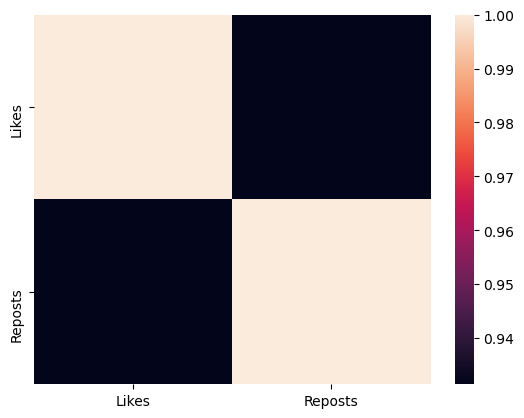

In [221]:
playlists_df_after_fill = playlists_df[['Likes', 'Reposts']].fillna(0)
sns.heatmap(playlists_df_after_fill.corr())

Those playlists with many Likes will have many Reposts

## References
